In [11]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

start_time = time.time()

In [12]:
data = pd.read_csv('../data/datasets_processed/Harel_TIL_data.csv', index_col='Unnamed: 0')
response = pd.read_csv('../data/datasets_processed/Harel_TIL_response.csv', index_col='Unnamed: 0')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

In [13]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_Harel_TIL.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [14]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response.values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [15]:
# define training params
alpha1_list = np.logspace(-3,-2,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_list_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [16]:
X_train_lower = np.linalg.cholesky(L_norm.todense())

# Lasso + LapRidge

In [17]:
def loss_fn(X,Y, L, alpha1, alpha2, beta):
    return 0.5/(len(X)) * cp.norm2(cp.matmul(X, beta) - Y)**2 + \
           alpha1 * cp.norm1(beta) + \
           alpha2 * cp.sum(cp.quad_form(beta,L)) 

alpha1_list = np.logspace(-1,0,15)
alpha2_list = np.logspace(-1,2,15)
alpha_pairs = list(itertools.product(alpha1_list, alpha2_list))

def run(pair):
    beta = cp.Variable(X_train.shape[1])
    alpha1 = cp.Parameter(nonneg=True)
    alpha2 = cp.Parameter(nonneg=True)
    alpha1.value = pair[0]
    alpha2.value = pair[1]
    
    problem = cp.Problem(cp.Minimize(loss_fn(X_train, y_train, L_norm, alpha1, alpha2, beta )))
    problem.solve(solver = cp.ECOS, verbose = True)

    return beta.value

In [19]:
betas = Parallel(n_jobs=-1, verbose=10)(delayed(run)(pair) for pair in alpha_pairs)
feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in betas]
feats_wf = [i for i in feats if len(i) != 0]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 250.4min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 271.4min
[Parallel(n_jobs=-1)]: Done  57 out of 225 | elapsed: 320.9min remaining: 945.8min
[Parallel(n_jobs=-1)]: Done  80 out of 225 | elapsed: 344.2min remaining: 623.8min
[Parallel(n_jobs=-1)]: Done 103 out of 225 | elapsed: 521.0min remaining: 617.1min
[Parallel(n_jobs=-1)]: Done 126 out of 225 | elapsed: 563.2min remaining: 442.5min
[Parallel(n_jobs=-1)]: Done 149 out of 225 | elapsed: 573.2min remaining: 292.4min
[Parallel(n_jobs=-1)]: Done 172 out of 225 | elapsed: 586.7min remaining: 180.8min
[Parallel(n_jobs=-1)]: Done 195 out of 225 | elapsed: 638.4min remaining: 98.2min
[Parallel(n_jobs=-1)]: Done 218 out of 225 | elapsed: 645.6min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 653.6min finished


In [20]:
regr = LinearRegression()
scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
train_scores = [i[0] for i in scores]
test_scores = [i[1] for i in scores]

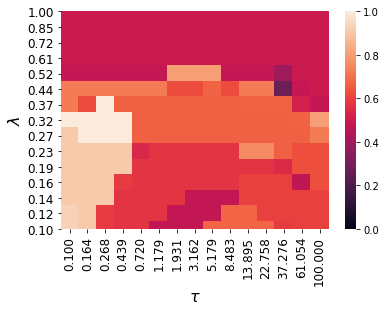

In [21]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [22]:
np.where(test_scores == min(test_scores))

(array([147]),)

In [23]:
feats[147]

array([2872, 2754, 1355,  669])

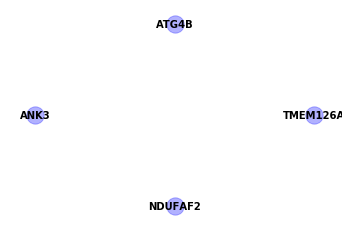

In [24]:
getTranslatedNodes(feats[147], [1,1,1,1,1,1,1,1,1,1,1,1], num_to_node, g, )

In [25]:
min(test_scores)

0.2744738292424032

# MCP + LapRidge

In [63]:
results = {}
feats_list = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'mcp')
    s.train()
    beta = s.coef()['beta']
    
    #betas = np.concatenate(beta)
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 9, 6, 7, 7, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[9, 9, 6, 7, 7, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 6, 7, 7, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 6, 7, 6, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 6, 7, 6, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 9, 8, 8, 6, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 7, 8, 6, 5, 3, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 7, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 7, 6, 6, 5, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 8, 6, 5, 3, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 8, 6, 5, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 9, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 8, 3, 1, 0, 0

In [64]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

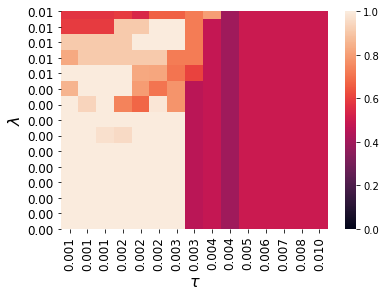

In [65]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha_list, alpha_list, save_location = None)

In [66]:
min(test_scores)

0.39476307859438076

In [67]:
np.where(test_scores == min(test_scores))

(array([  9,  24,  39,  54,  69,  84,  99, 114, 129, 144, 159, 174, 189,
        204, 219]),)

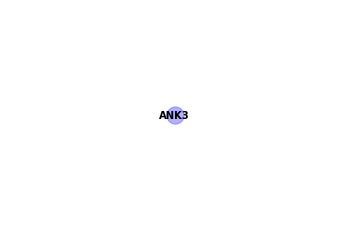

In [52]:
getTranslatedNodes(feats_list[39], [1,1,1,1,1], num_to_node, g)

# SCAD + LapRidge

In [68]:
results = {}
feats_list = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'scad')
    s.train()
    beta = s.coef()['beta']
    
    #betas = np.concatenate(beta)
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 10, 10, 10, 10, 9, 6, 5, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 6, 5, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 6, 6, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 6, 6, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 7, 6, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 7, 6, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 9, 7, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 9, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 2, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 8, 3, 1, 0, 0, 0, 0, 0]
Training is over.
[10, 1

In [69]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

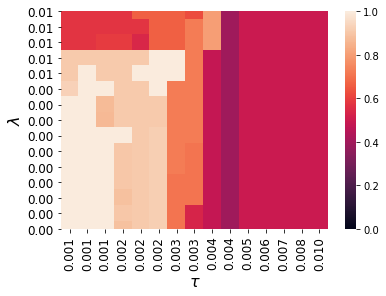

In [70]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha_list, alpha_list, save_location = None)

In [72]:
min(test_scores)

0.39476307859438076

In [73]:
np.where(test_scores == min(test_scores))

(array([  9,  24,  39,  54,  69,  84,  99, 114, 129, 144, 159, 174, 189,
        204, 219]),)

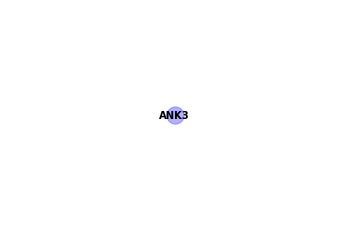

In [74]:
getTranslatedNodes(feats_list[39], [1,1,1,1,1], num_to_node, g)